# Coronavirus Data Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
spark.sparkContext.applicationId

'application_1636170550178_0007'

In [3]:
pd.options.display.max_columns = 35

In [4]:
from foresight.discern import broadcast_discern, push_discern, pop_discern

### care management new default will be 5e259fd5-75b5-4d49-82d3-2d4e92dca831 for any new clients or 
###  any algorithm wiki not line for line with Cerner Standard then would be using the new context  

pd.set_option('display.max_colwidth', None)

# Location of the discernontology database
root = 's3://consult-datalab-persistence-s3-data/discernontology/v1/'   ##<------------- change it to your stack without the v1/

contextid = ['da0acee6-1e2e-4384-9fc7-a58c259d0c50', '5E259FD575B54D4982D32D4E92DCA831'] 

# Loop that removes all hypthens and captializes all letters. Sets up the file location
for contextid in contextid:
    contextid = contextid.upper().replace("-", "")
    push_discern(spark, contextid, discern_root=root)
    print(contextid)

defaultcontext = 'DA0ACEE61E2E43849FC7A58C259D0C50'   
defaultcontext1 = '5E259FD575B54D4982D32D4E92DCA831' 

DA0ACEE61E2E43849FC7A58C259D0C50
5E259FD575B54D4982D32D4E92DCA831


In [5]:
db = "real_world_data_2021_Q2"
spark.sql("USE {}".format(db))
print("Using database: {},".format(db))

Using database: real_world_data_2021_Q2,


In [6]:
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,real_world_data_2021_q2,allergy,False
1,real_world_data_2021_q2,clinical_event,False
2,real_world_data_2021_q2,condition,False
3,real_world_data_2021_q2,demographics,False
4,real_world_data_2021_q2,encounter,False
5,real_world_data_2021_q2,immunization,False
6,real_world_data_2021_q2,lab,False
7,real_world_data_2021_q2,measurement,False
8,real_world_data_2021_q2,medication,False
9,real_world_data_2021_q2,medication_administration,False


### Create Variables for Queries

In [7]:
# Look back days variables
daysInterval = 365
print(daysInterval)
maxDays = 365
print(maxDays)
oneYearInterval=365
print(oneYearInterval)

# Username variable
user_id = 'rc047407'           ####<-------------------- change to your user id (Ex: tl068507)
userName = 'user_' + user_id
print(userName)

# Algorithm name variable
algorithmName='CoronavirusLengthOfStay_HighLevel'
print(algorithmName)

365
365
365
user_rc047407
CoronavirusLengthOfStay_HighLevel


In [8]:
spark.sql("""CREATE SCHEMA IF NOT EXISTS {userName}""".format(**{
    'userName':userName
})).show()

++
||
++
++



In [ ]:
conavirusPatientsDf =  spark.sql(f"""


    SELECT distinct
        e.tenant
        ,e.personId
        ,1 as has_or_been_exposed_to_coronavirus
        ,ROUND((datediff(date_add(current_date(), - 0), d.birthDate))/365,0) as age

        FROM {db}.encounter e

        JOIN {db}.demographics d
            ON e.personId = d.personId
              and e.tenant = d.tenant
               
        JOIN {db}.condition c
            ON e.personId = c.personId
              and e.encounterId = c.encounterId
              and e.tenant = c.tenant
              and ( HAS_ANY_CONCEPT_IN_CONTEXT(c.conditionCode, array('CORONAVIRUS_COVID_19_DISEASE_CLIN',
                    'CORONAVIRUS_COVID_19_POSITIVE_CLIN', 'CORONAVIRUS_COVID_19_EXPOSURE_TO_CLIN',
                    'CORONAVIRUS_COVID_19_TRAVEL_TO_AREA_AFFECTED_CLIN'), '{defaultcontext}' ) )  
                    
                       
                                   
   
       

""")

In [ ]:
# Drop existing table, if there was one 
spark.sql(f"""DROP TABLE IF EXISTS {userName}.{algorithmName}_ConavirusPatients""").show() 

In [11]:
conavirusPatientsDf.write.saveAsTable(f"""{userName}.{algorithmName}_ConavirusPatients """)

In [12]:
vaccinedPatientsDf = spark.sql(f"""


    SELECT distinct 
        e.tenant
        ,e.personId
        ,m.startDate as vaccine_date
        ,1 as vaccinated
  
        FROM {db}.encounter e

        JOIN {db}.medication m
            ON  e.personId = m.personId
                and e.tenant = m.tenant
                and e.encounterId = m.encounterId
                AND HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_207_MED','SARS_COV2_COVID19_CVX_207_VAC',
                            'SARS_COV2_COVID19_CVX_208_MED','SARS_COV2_COVID19_CVX_208_VAC',
                            'SARS_COV2_COVID19_CVX_210_MED','SARS_COV2_COVID19_CVX_210_VAC',
                            'SARS_COV2_COVID19_CVX_212_MED','SARS_COV2_COVID19_CVX_212_VAC',
                            'SARS_COV2_COVID19_CVX_213_MED','SARS_COV2_COVID19_CVX_213_VAC',
                            'SARS_COV2_COVID19_CVX_500_MED','SARS_COV2_COVID19_CVX_500_VAC',
                            'SARS_COV2_COVID19_CVX_510_MED','SARS_COV2_COVID19_CVX_510_VAC',
                            'SARS_COV2_COVID19_CVX_511_MED','SARS_COV2_COVID19_CVX_511_VAC'), '{defaultcontext}' )
                            
      
   UNION
   
    SELECT distinct 
        e.tenant
        ,e.personId
         ,p.serviceStartDate as vaccine_date
        ,1 as vaccinated
  
        FROM {db}.encounter e

        JOIN {db}.procedure p
            ON  e.personId = p.personId
                and e.tenant = p.tenant
                and e.encounterId = p.encounterId
                AND HAS_ANY_CONCEPT_IN_CONTEXT(p.procedureCode,
                            array('SARS_COV2_COVID19_SINGLE_DOSE_VACCINE_PROC','SARS_COV2_COVID19_VACCINE_PROC'),
                               '{defaultcontext}' ) 
                            
                        
   
   
""")

In [13]:
# Drop existing table, if there was one 
spark.sql(f"""DROP TABLE IF EXISTS {userName}.{algorithmName}_VaccinatedPatients""").show() 

++
||
++
++



In [14]:
vaccinedPatientsDf.write.saveAsTable(f"""{userName}.{algorithmName}_VaccinatedPatients """)

In [15]:
vaccineDf = spark.sql(f"""


    SELECT distinct 
        e.tenant
        ,e.personId
        ,e.encounterId
        ,e.type.standard.primaryDisplay as encounterType
        ,e.serviceDate
        ,m.startDate as vaccine_date
        ,1 as vaccinated

  
        FROM {db}.encounter e

        JOIN {db}.medication m
            ON  e.personId = m.personId
                and e.tenant = m.tenant
                and e.encounterId = m.encounterId
                AND HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_207_MED','SARS_COV2_COVID19_CVX_207_VAC',
                            'SARS_COV2_COVID19_CVX_208_MED','SARS_COV2_COVID19_CVX_208_VAC',
                            'SARS_COV2_COVID19_CVX_210_MED','SARS_COV2_COVID19_CVX_210_VAC',
                            'SARS_COV2_COVID19_CVX_212_MED','SARS_COV2_COVID19_CVX_212_VAC',
                            'SARS_COV2_COVID19_CVX_213_MED','SARS_COV2_COVID19_CVX_213_VAC',
                            'SARS_COV2_COVID19_CVX_500_MED','SARS_COV2_COVID19_CVX_500_VAC',
                            'SARS_COV2_COVID19_CVX_510_MED','SARS_COV2_COVID19_CVX_510_VAC',
                            'SARS_COV2_COVID19_CVX_511_MED','SARS_COV2_COVID19_CVX_511_VAC'), '{defaultcontext}' )
                            
        JOIN {userName}.{algorithmName}_Hospital h  
            ON  e.personId = h.personId
                and e.tenant = h.tenant
                
      
   UNION
   
    SELECT distinct 
        e.tenant
        ,e.personId
        ,e.encounterId
        ,e.type.standard.primaryDisplay as encounterType
        ,e.serviceDate
        ,p.serviceStartDate as vaccine_date
        ,1 as vaccinated
  
        FROM {db}.encounter e

        JOIN {db}.procedure p
            ON  e.personId = p.personId
                and e.tenant = p.tenant
                and e.encounterId = p.encounterId
                AND HAS_ANY_CONCEPT_IN_CONTEXT(p.procedureCode,
                            array('SARS_COV2_COVID19_SINGLE_DOSE_VACCINE_PROC','SARS_COV2_COVID19_VACCINE_PROC'),
                               '{defaultcontext}' ) 
                            
        JOIN {userName}.{algorithmName}_Hospital h  
            ON  e.personId = h.personId
                and e.tenant = h.tenant
                       
   
   
""")

In [16]:
spark.sql(f"""DROP TABLE IF EXISTS {userName}.{algorithmName}_Vaccine""").show() 

++
||
++
++



In [17]:
vaccineDf.write.saveAsTable(f"""{userName}.{algorithmName}_Vaccine""")

In [18]:
vaccineDetailDf = spark.sql(f"""select 
    v.tenant
    ,v.personId
    ,v.encounterId
    ,v.encounterType
    ,v.serviceDate
    ,v.vaccine_date
    ,v.vaccinated
    ,if(HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_207_MED','SARS_COV2_COVID19_CVX_207_VAC'),
                            '{defaultcontext}'),1,0) as taken_Moderna_vaccine
    ,if(HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_208_MED','SARS_COV2_COVID19_CVX_208_VAC'),
                            '{defaultcontext}'),1,0) as taken_Pfizer_vaccine  
    ,if(HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_210_MED','SARS_COV2_COVID19_CVX_210_VAC'),
                            '{defaultcontext}'),1,0) as taken_AstraZeneca_vaccine   
    ,if(HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_212_MED','SARS_COV2_COVID19_CVX_212_VAC'),
                            '{defaultcontext}'),1,0) as taken_Janssen_vaccine 
    ,if(HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_213_MED','SARS_COV2_COVID19_CVX_213_VAC'),
                            '{defaultcontext}'),1,0) as taken_Unspecified_vaccine  
    ,if(HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_500_MED','SARS_COV2_COVID19_CVX_500_VAC',
                                  'SARS_COV2_COVID19_CVX_510_MED','SARS_COV2_COVID19_CVX_510_VAC',
                                  'SARS_COV2_COVID19_CVX_511_MED','SARS_COV2_COVID19_CVX_511_VAC'),
                            '{defaultcontext}'),1,0) as taken_Non_US_vaccine  
     ,if(HAS_ANY_CONCEPT_IN_CONTEXT(p.procedureCode,
                            array('SARS_COV2_COVID19_SINGLE_DOSE_VACCINE_PROC'),
                            '{defaultcontext}'),1,0) as taken_single_dose   
     ,if(HAS_ANY_CONCEPT_IN_CONTEXT(p.procedureCode,
                            array('SARS_COV2_COVID19_VACCINE_PROC'),
                            '{defaultcontext}'),1,0) as taken_multiple_doses                         
      
      FROM {userName}.{algorithmName}_Vaccine v
      
      LEFT JOIN {db}.medication m
            ON  v.personId = m.personId
                and v.tenant = m.tenant
                and v.encounterId = m.encounterId
                AND HAS_ANY_CONCEPT_IN_CONTEXT(m.drugCode,
                            array('SARS_COV2_COVID19_CVX_207_MED','SARS_COV2_COVID19_CVX_207_VAC',
                            'SARS_COV2_COVID19_CVX_208_MED','SARS_COV2_COVID19_CVX_208_VAC',
                            'SARS_COV2_COVID19_CVX_210_MED','SARS_COV2_COVID19_CVX_210_VAC',
                            'SARS_COV2_COVID19_CVX_212_MED','SARS_COV2_COVID19_CVX_212_VAC',
                            'SARS_COV2_COVID19_CVX_213_MED','SARS_COV2_COVID19_CVX_213_VAC',
                            'SARS_COV2_COVID19_CVX_500_MED','SARS_COV2_COVID19_CVX_500_VAC',
                            'SARS_COV2_COVID19_CVX_510_MED','SARS_COV2_COVID19_CVX_510_VAC',
                            'SARS_COV2_COVID19_CVX_511_MED','SARS_COV2_COVID19_CVX_511_VAC'), '{defaultcontext}' )    
         
      LEFT JOIN {db}.procedure p
            ON  v.personId = p.personId
                and v.tenant = p.tenant
                and v.encounterId = p.encounterId
                AND HAS_ANY_CONCEPT_IN_CONTEXT(p.procedureCode,
                            array('SARS_COV2_COVID19_SINGLE_DOSE_VACCINE_PROC','SARS_COV2_COVID19_VACCINE_PROC'),
                               '{defaultcontext}' )    
    
    """)

In [19]:
spark.sql(f"""DROP TABLE IF EXISTS {userName}.{algorithmName}_Vaccine_Detail""").show() 

++
||
++
++



In [20]:
vaccineDetailDf.write.saveAsTable(f"""{userName}.{algorithmName}_Vaccine_Detail""")

In [21]:
spark.sql(f"""select * from {userName}.{algorithmName}_Vaccine """).printSchema()

root
 |-- tenant: integer (nullable = true)
 |-- personId: string (nullable = true)
 |-- encounterId: string (nullable = true)
 |-- encounterType: string (nullable = true)
 |-- serviceDate: string (nullable = true)
 |-- vaccine_date: string (nullable = true)
 |-- vaccinated: integer (nullable = true)



In [10]:
spark.sql(f"""select * from {userName}.{algorithmName}_Vaccine_Detail """).count()

7166

In [22]:
spark.sql(f"""select * from {userName}.{algorithmName}_Vaccine_Detail """).printSchema()

root
 |-- tenant: integer (nullable = true)
 |-- personId: string (nullable = true)
 |-- encounterId: string (nullable = true)
 |-- encounterType: string (nullable = true)
 |-- serviceDate: string (nullable = true)
 |-- vaccine_date: string (nullable = true)
 |-- vaccinated: integer (nullable = true)
 |-- taken_Moderna_vaccine: integer (nullable = true)
 |-- taken_Pfizer_vaccine: integer (nullable = true)
 |-- taken_AstraZeneca_vaccine: integer (nullable = true)
 |-- taken_Janssen_vaccine: integer (nullable = true)
 |-- taken_Unspecified_vaccine: integer (nullable = true)
 |-- taken_Non_US_vaccine: integer (nullable = true)
 |-- taken_single_dose: integer (nullable = true)
 |-- taken_multiple_doses: integer (nullable = true)



In [23]:
spark.sql(f"""select * from {userName}.{algorithmName}_Vaccine_Detail limit(25) """).toPandas()

,tenant,personId,encounterId,encounterType,serviceDate,vaccine_date,vaccinated,taken_Moderna_vaccine,taken_Pfizer_vaccine,taken_AstraZeneca_vaccine,taken_Janssen_vaccine,taken_Unspecified_vaccine,taken_Non_US_vaccine,taken_single_dose,taken_multiple_doses
0,33,00afdba6-b8d0-469d-97a1-988b5423626b,49dd2b05-24a3-4365-89bc-2cd688e8252c,Seen by nurse,2021-02-10T13:55:05+00:00,2021-02-10T14:00:00+00:00,1,0,1,0,0,0,0,0,0
1,37,06367269-b31f-41ff-9b3c-ab4dc2fea354,06b48e93-bdd0-4823-a429-5270457e4dfe,None,2021-01-29T15:55:54+00:00,2021-01-29T16:00:00+00:00,1,0,1,0,0,0,0,0,0
2,37,06367269-b31f-41ff-9b3c-ab4dc2fea354,fe06d005-c88f-41df-ac7e-7a71edcbb8ba,None,2021-01-06T15:54:32+00:00,2021-01-06T16:00:00+00:00,1,0,1,0,0,0,0,0,0
3,63,0b7548fd-894d-4dbd-be5a-e8f02ff036d9,d63fd056-a20f-4afa-8b9d-4b2a3051a927,Attending clinic,2021-03-02T15:50:51+00:00,2021-03-02T16:08:00+00:00,1,0,1,0,0,0,0,0,0
4,81,0d190c33-ce80-41d2-9bb2-db50e5bbd948,78508c8b-6072-44e7-8c17-3417d907c2f2,None,2021-05-07T14:24:10+00:00,2021-05-07T15:00:00+00:00,1,0,1,0,0,0,0,0,0
5,36,0ecd4b45-92aa-4302-8d72-224864a8a445,e2744440-40b3-437a-b647-48e679b21154,Attending clinic,2021-01-21T01:46:00+00:00,2021-01-12T01:48:02+00:00,1,1,0,0,0,0,0,0,0
6,36,18e0ee70-5043-40ca-9146-9c3f13e3ccc2,f3178784-7949-44df-b4d0-9d91f2f3c565,Attending clinic,2020-12-30T22:39:00+00:00,2020-12-30T22:40:45+00:00,1,0,1,0,0,0,0,0,0
7,14,1978bddb-9b07-4d02-8610-3aab1afb318b,71c51617-a5ec-45c4-b39a-5f2354443b8a,None,2021-01-30T13:15:00+00:00,2021-01-30T13:25:43+00:00,1,0,1,0,0,0,0,0,0
8,81,23f286a3-3e54-4c11-a8aa-9233063d8cb7,97cf7b13-907f-4b44-9eee-45b876c1e619,None,2021-02-21T13:30:00+00:00,2021-02-21T14:00:00+00:00,1,0,1,0,0,0,0,0,0
9,14,334ae902-3e8c-4365-b953-cc6a19890a01,dcdf0c15-5539-485e-a347-9d7ab1a7783c,None,2021-02-26T18:40:00+00:00,2021-02-26T18:44:35+00:00,1,0,1,0,0,0,0,0,0


In [24]:
allDf = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

     --   and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
     --          or v.vaccine_date is null) 
               
               
    --        and  ( datediff(h.serviceDate, v.vaccine_date) > 0
    --           and v.vaccine_date is not null)        
      

  
""") 

In [25]:
mean_length_of_stay = allDf.first().mean_length_of_stay
std_length_of_stay = allDf.first().std_length_of_stay
print(mean_length_of_stay)
print(std_length_of_stay)
print(allDf.toPandas())

9.76
13.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0             312864                   2                1553   

   mean_length_of_stay  std_length_of_stay  
0                 9.76                13.0  


In [26]:
withVaccineDf = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

     --   and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
     --          or v.vaccine_date is null) 
               
               
            and  ( datediff(h.serviceDate, v.vaccine_date) > 0
               and v.vaccine_date is not null)        
      

  
""")

In [27]:
mean_length_of_stay_with_vaccine = withVaccineDf.first().mean_length_of_stay
std_length_of_stay_with_vaccine = withVaccineDf.first().std_length_of_stay
print(mean_length_of_stay_with_vaccine)
print(std_length_of_stay_with_vaccine)
print(withVaccineDf.toPandas())

7.18
6.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0                399                   2                  50   

   mean_length_of_stay  std_length_of_stay  
0                 7.18                 6.0  


In [28]:
withoutVaccineDf = spark.sql(f"""
  select
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay)) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

        and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
               or v.vaccine_date is null) 
               
               
     --       and  ( datediff(h.serviceDate, v.vaccine_date) > 0
     --          and v.vaccine_date is not null)        
      

  
""")

In [29]:
mean_length_of_stay_without_vaccine = withoutVaccineDf.first().mean_length_of_stay
std_length_of_stay_without_vaccine = withoutVaccineDf.first().std_length_of_stay
print(mean_length_of_stay_without_vaccine)
print(std_length_of_stay_without_vaccine)
print(withoutVaccineDf.toPandas())

9.77
13.0
   count_of_patients  min_length_of_stay  max_length_of_stay  \
0             312452                   2                1553   

   mean_length_of_stay  std_length_of_stay  
0                 9.77                13.0  


In [30]:
spark.sql(f"""
  select t.speciality,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

        and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
               or v.vaccine_date is null) 
               
               
    --        and  ( datediff(h.serviceDate, v.vaccine_date) > 0
    --           and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,speciality,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,Academic Medical Center,9637,2,841,10.09,15.76
1,Community Hospital,3462,2,1039,8.57,24.11
2,Critical Access Hospital,1240,2,234,6.02,7.93
3,Hospital,57391,2,861,9.96,12.11
4,IDN/Regional Health Authority,239673,2,1553,9.74,12.49
5,Pediatric Medical Center,1049,2,612,10.11,30.45


In [31]:
spark.sql(f"""
  select t.speciality,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

  --      and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
  --             or v.vaccine_date is null) 
               
               
            and  ( datediff(h.serviceDate, v.vaccine_date) > 0
               and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,speciality,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,Academic Medical Center,8,2,27,9.25,9.16
1,Community Hospital,20,3,10,5.45,2.68
2,Critical Access Hospital,4,3,10,4.75,3.50
3,Hospital,91,2,50,8.57,8.33
4,IDN/Regional Health Authority,276,2,23,6.82,4.36


In [32]:
spark.sql(f"""
  select t.bed_size,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

        and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
               or v.vaccine_date is null) 
               
               
    --        and  ( datediff(h.serviceDate, v.vaccine_date) > 0
    --           and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,bed_size,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,100-199,2184,2,154,8.87,10.29
1,200-299,5385,2,345,8.88,12.81
2,300-499,32570,2,861,9.64,11.99
3,500-999,61276,2,1364,9.71,14.18
4,<100,3977,2,1039,8.27,26.55
5,>=1000,207060,2,1553,9.86,12.10


In [33]:
spark.sql(f"""
  select t.bed_size,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

   --     and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
   --            or v.vaccine_date is null) 
               
               
            and  ( datediff(h.serviceDate, v.vaccine_date) > 0
               and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,bed_size,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,100-199,3,8,13,9.67,2.89
1,200-299,5,3,5,3.80,1.10
2,300-499,19,2,27,7.00,6.19
3,500-999,138,2,50,7.87,7.19
4,<100,27,2,20,6.04,4.00
5,>=1000,207,2,23,6.92,4.50


In [34]:
spark.sql(f"""
  select t.segment,
         count(h.personId) as count_of_patients,
         min(h.length_of_stay) as min_length_of_stay,
         max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay,
         round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
  join {db}.tenant_attributes t
            ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

   --     and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
   --            or v.vaccine_date is null) 
               
               
            and  ( datediff(h.serviceDate, v.vaccine_date) > 0
               and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,segment,count_of_patients,min_length_of_stay,max_length_of_stay,mean_length_of_stay,std_length_of_stay
0,Academic,24,2,27,7.58,7.26
1,Childrens,2,8,8,8.00,0.00
2,Community Healthcare,19,2,10,5.47,2.80
3,Community Hospital,3,3,20,9.00,9.54
4,Critical Access,2,3,10,6.50,4.95
5,IDN,228,2,37,7.61,5.69
6,Regional Hospital,121,2,50,6.50,5.39


In [41]:
stdVar = spark.sql(f"""
  select  round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant

   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
       
""")
stdValue = stdVar.first()['std_length_of_stay']
print(stdValue)

12.8


In [37]:
stdVar = spark.sql(f"""
  select  round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant

   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
 
      and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
             or v.vaccine_date is null) 
       
""")
stdValue_nonVac = stdVar.first()['std_length_of_stay']
print(stdValue_nonVac)

12.81


In [38]:
stdVar = spark.sql(f"""
  select  round(std(h.length_of_stay),2) as std_length_of_stay
       
  from {userName}.{algorithmName}_Hospital h
  
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant

   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
               
      and  ( datediff(h.serviceDate, v.vaccine_date) > 0
             and v.vaccine_date is not null)        
      
    
""")
stdValue_vac = stdVar.first()['std_length_of_stay']
print(stdValue_vac)

5.62


In [47]:
spark.sql(f"""

          select
              case
                when age >= 90 then "90+"
                when age >= 85 and age < 90 then "85-89"
                when age >= 80 and age < 85 then "80-85"
                when age >= 75 and age < 80 then "75-79"
                when age >= 70 and age < 75 then "70-74"
                when age >= 65 and age < 70 then "65-69"
                when age >= 60 and age < 65 then "60-65"
                when age >= 55 and age < 60 then "55-59"
                when age >= 50 and age < 55 then "50-54"
                when age >= 45 and age < 50 then "45-49"
                when age >= 40 and age < 45 then "40-45"
                when age >= 35 and age < 40 then "35-39"
                when age >= 30 and age < 35 then "30-34"
                when age >= 25 and age < 30 then "25-29"
                when age >= 20 and age < 25 then "20-25"
                when age >= 12 and age < 20 then "12-19"
                when age >= 0 and age < 12 then "0-12"
              else "unknown"
              end as age_range
              , count(h.personId) as count_of_non_vaccinated_patients
              , round(mean(h.length_of_stay),2) as mean_length_of_stay
        from {userName}.{algorithmName}_Hospital h
          
        left join {userName}.{algorithmName}_Vaccine v
            on h.personid = v.personId
              and h.tenant = v.tenant

           where    
              datediff(h.serviceDate, h.dischargeDate) < 0
              and h.length_of_stay > 0
              and h.length_of_stay < 3*{stdValue_nonVac}

              and length(h.dischargeDate) > 3
              and length(h.serviceDate) > 3


              and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
                     or v.vaccine_date is null) 
               
        group by 1
        order by 1
     
""").toPandas()

,age_range,count_of_non_vaccinated_patients,mean_length_of_stay
0,0-12,4341,5.37
1,12-19,2762,6.09
2,20-25,4828,5.15
3,25-29,7081,5.45
4,30-34,9014,6.10
5,35-39,10274,6.71
6,40-45,11826,7.30
7,45-49,14427,7.77
8,50-54,19794,8.21
9,55-59,24458,8.69


In [39]:
spark.sql(f"""

        select count(h.personId) as count_of_non_vaccinated_patients
               , round(mean(h.length_of_stay),2) as mean_length_of_stay
        from {userName}.{algorithmName}_Hospital h
          
        left join {userName}.{algorithmName}_Vaccine v
            on h.personid = v.personId
              and h.tenant = v.tenant

           where    
              datediff(h.serviceDate, h.dischargeDate) < 0
              and h.length_of_stay > 0
              and h.length_of_stay < 3*{stdValue_nonVac}

              and length(h.dischargeDate) > 3
              and length(h.serviceDate) > 3


              and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
                    or v.vaccine_date is not null)  

""").toPandas()

,count_of_non_vaccinated_patients,mean_length_of_stay
0,8283,7.69


In [28]:
spark.sql(f"""

          select
              case
                when age >= 90 then "90+"
                when age >= 85 and age < 90 then "85-89"
                when age >= 80 and age < 85 then "80-85"
                when age >= 75 and age < 80 then "75-79"
                when age >= 70 and age < 75 then "70-74"
                when age >= 65 and age < 70 then "65-69"
                when age >= 60 and age < 65 then "60-65"
                when age >= 55 and age < 60 then "55-59"
                when age >= 50 and age < 55 then "50-54"
                when age >= 45 and age < 50 then "45-49"
                when age >= 40 and age < 45 then "40-45"
                when age >= 35 and age < 40 then "35-39"
                when age >= 30 and age < 35 then "30-34"
                when age >= 25 and age < 30 then "25-29"
                when age >= 20 and age < 25 then "20-25"
                when age >= 12 and age < 20 then "12-19"
                when age >= 0 and age < 12 then "0-12"
                else "unknown"
                end as age_range
              , count(h.personId) as count_of_non_vaccinated_patients
              , round(mean(h.length_of_stay),2) as mean_length_of_stay
        from {userName}.{algorithmName}_Hospital h
          
        left join {userName}.{algorithmName}_Vaccine v
            on h.personid = v.personId
              and h.tenant = v.tenant

           where    
              datediff(h.serviceDate, h.dischargeDate) < 0
              and h.length_of_stay > 0
              and h.length_of_stay < 3*{stdValue_vac}

              and length(h.dischargeDate) > 3
              and length(h.serviceDate) > 3


              and  ( datediff(h.serviceDate, v.vaccine_date) > 0
                    and v.vaccine_date is not null)  
               
        group by 1
        order by 1
     
""").toPandas()

,age_range,count_of_non_vaccinated_patients,mean_length_of_stay
0,12-19,1,4.00
1,20-25,4,5.25
2,25-29,1,2.00
3,30-34,9,3.67
4,35-39,5,4.60
5,40-45,15,5.53
6,45-49,12,3.83
7,50-54,14,5.71
8,55-59,25,4.52
9,60-65,18,8.22


In [32]:
spark.sql(f"""

          select count(h.personId) as count_of_non_vaccinated_patients
                , round(mean(h.length_of_stay),2) as mean_length_of_stay
        from {userName}.{algorithmName}_Hospital h
          
        left join {userName}.{algorithmName}_Vaccine v
            on h.personid = v.personId
              and h.tenant = v.tenant

           where    
              datediff(h.serviceDate, h.dischargeDate) < 0
              and h.length_of_stay > 0
              and h.length_of_stay < 3*{stdValue_vac}

              and length(h.dischargeDate) > 3
              and length(h.serviceDate) > 3


              and  ( datediff(h.serviceDate, v.vaccine_date) > 0
                    and v.vaccine_date is not null)  
               
      
""").toPandas()

,count_of_non_vaccinated_patients,mean_length_of_stay
0,368,5.97


In [45]:
spark.sql(f"""

          select
              case
                when age >= 90 then "90+"
                when age >= 85 and age < 90 then "85-89"
                when age >= 80 and age < 85 then "80-85"
                when age >= 75 and age < 80 then "75-79"
                when age >= 70 and age < 75 then "70-74"
                when age >= 65 and age < 70 then "65-69"
                when age >= 60 and age < 65 then "60-65"
                when age >= 55 and age < 60 then "55-59"
                when age >= 50 and age < 55 then "50-54"
                when age >= 45 and age < 50 then "45-49"
                when age >= 40 and age < 45 then "40-45"
                when age >= 35 and age < 40 then "35-39"
                when age >= 30 and age < 35 then "30-34"
                when age >= 25 and age < 30 then "25-29"
                when age >= 20 and age < 25 then "20-25"
                when age >= 12 and age < 20 then "12-19"
                when age >= 0 and age < 12 then "0-12"
                else "unknown"
                end as age_range
              , count(h.personId) as count_of_non_vaccinated_patients
              , round(mean(h.length_of_stay),2) as mean_length_of_stay
        from {userName}.{algorithmName}_Hospital h
          
        left join {userName}.{algorithmName}_Vaccine v
            on h.personid = v.personId
              and h.tenant = v.tenant

           where    
              datediff(h.serviceDate, h.dischargeDate) < 0
              and h.length_of_stay > 0
              and h.length_of_stay < 3*{stdValue}

              and length(h.dischargeDate) > 3
              and length(h.serviceDate) > 3


        group by 1
        order by 1
     
""").toPandas()

,age_range,count_of_non_vaccinated_patients,mean_length_of_stay
0,0-12,4341,5.37
1,12-19,2763,6.09
2,20-25,4832,5.15
3,25-29,7082,5.45
4,30-34,9023,6.10
5,35-39,10279,6.71
6,40-45,11841,7.29
7,45-49,14439,7.77
8,50-54,19808,8.21
9,55-59,24485,8.69


In [46]:
spark.sql(f"""

        select count(h.personId) as count_of_non_vaccinated_patients
              , round(mean(h.length_of_stay),2) as mean_length_of_stay
        from {userName}.{algorithmName}_Hospital h
          
        left join {userName}.{algorithmName}_Vaccine v
            on h.personid = v.personId
              and h.tenant = v.tenant

           where    
              datediff(h.serviceDate, h.dischargeDate) < 0
              and h.length_of_stay > 0
              and h.length_of_stay < 3*{stdValue}

              and length(h.dischargeDate) > 3
              and length(h.serviceDate) > 3

     
""").toPandas()

,count_of_non_vaccinated_patients,mean_length_of_stay
0,306016,8.66


In [44]:
spark.sql(f"""
  select h.tenant_segment as segment,
         count(h.personId) as count_of_patients,
  --       min(h.length_of_stay) as min_length_of_stay,
  --       max(h.length_of_stay) as max_length_of_stay,
         round(mean(h.length_of_stay),2) as mean_length_of_stay
       
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant
      
      
      
 -- join {db}.tenant_attributes t
 --           ON  h.tenant = t.tenant  
     
   where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and h.length_of_stay < 2*{stdValue}
 
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      

  --      and  ( datediff(h.serviceDate, v.vaccine_date) <= 0
  --             or v.vaccine_date is null) 
               
               
               
            and  ( datediff(h.serviceDate, v.vaccine_date) > 0
               and v.vaccine_date is not null)        
      

 
  group by 1 
  
 
  order by 1
  
     
""").toPandas()

,segment,count_of_patients,mean_length_of_stay
0,Academic,23,6.74
1,Childrens,2,8.00
2,Community Healthcare,19,5.47
3,Community Hospital,3,9.00
4,Critical Access,2,6.50
5,IDN,226,7.35
6,Regional Hospital,120,6.14


In [36]:
import matplotlib.pyplot as plt
from scipy.stats import norm

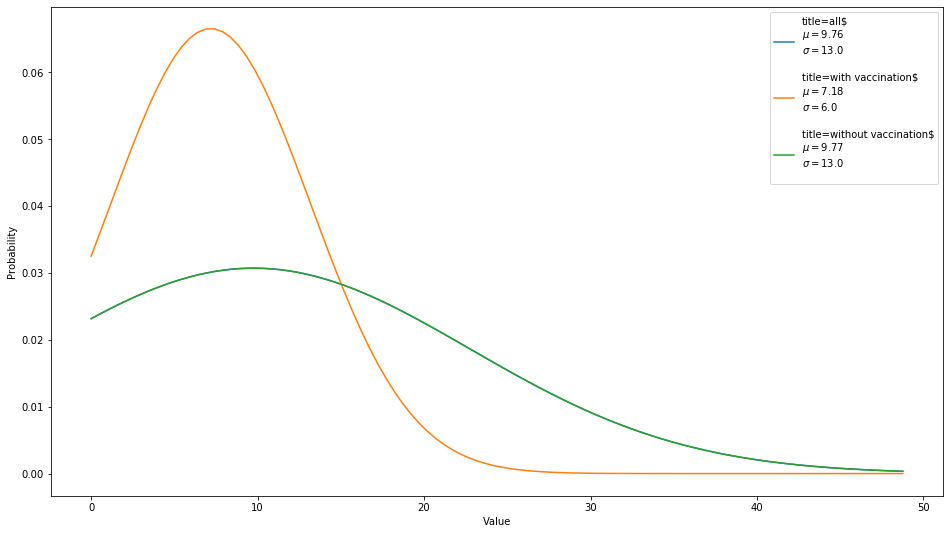

In [37]:
# generating multiple normal distributions
max_length_of_stay=mean_length_of_stay + 3*std_length_of_stay

domain = np.linspace(0, max_length_of_stay, 100) # dividing the distance between 0 and max_length_of_stay into 100 points

means = [mean_length_of_stay, mean_length_of_stay_with_vaccine, mean_length_of_stay_without_vaccine]
std_values = [std_length_of_stay, std_length_of_stay_with_vaccine, std_length_of_stay_without_vaccine]
title_values = ["all", "with vaccination", "without vaccination"]

plt.figure(figsize=(16, 9))
for title, mu, std in zip(title_values, means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"title={title}$\n$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

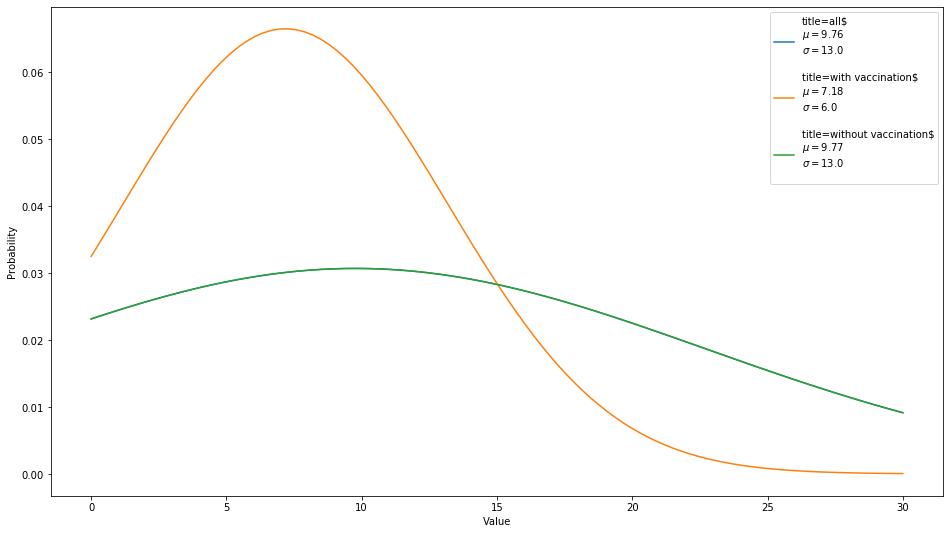

In [38]:
# generating multiple normal distributions
max_length_of_stay=30

domain = np.linspace(0, max_length_of_stay, 100) # dividing the distance between 0 and max_length_of_stay into 100 points

means = [mean_length_of_stay, mean_length_of_stay_with_vaccine, mean_length_of_stay_without_vaccine]
std_values = [std_length_of_stay, std_length_of_stay_with_vaccine, std_length_of_stay_without_vaccine]
title_values = ["all", "with vaccination", "without vaccination"]

plt.figure(figsize=(16, 9))
for title, mu, std in zip(title_values, means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"title={title}$\n$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

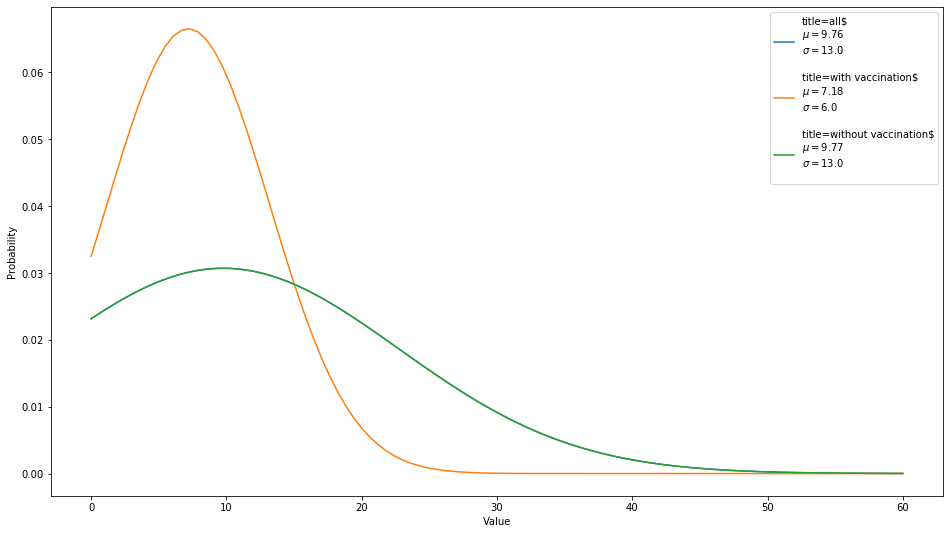

In [39]:
# generating multiple normal distributions
max_length_of_stay=60

domain = np.linspace(0, max_length_of_stay, 100) # dividing the distance between 0 and max_length_of_stay into 100 points

means = [mean_length_of_stay, mean_length_of_stay_with_vaccine, mean_length_of_stay_without_vaccine]
std_values = [std_length_of_stay, std_length_of_stay_with_vaccine, std_length_of_stay_without_vaccine]
title_values = ["all", "with vaccination", "without vaccination"]

plt.figure(figsize=(16, 9))
for title, mu, std in zip(title_values, means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"title={title}$\n$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

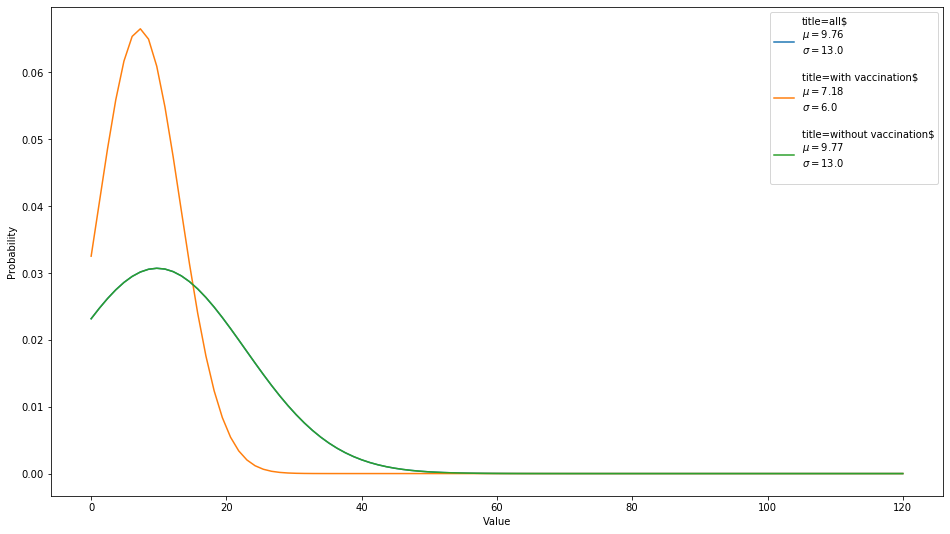

In [40]:
# generating multiple normal distributions
max_length_of_stay=120

domain = np.linspace(0, max_length_of_stay, 100) # dividing the distance between 0 and max_length_of_stay into 100 points

means = [mean_length_of_stay, mean_length_of_stay_with_vaccine, mean_length_of_stay_without_vaccine]
std_values = [std_length_of_stay, std_length_of_stay_with_vaccine, std_length_of_stay_without_vaccine]
title_values = ["all", "with vaccination", "without vaccination"]

plt.figure(figsize=(16, 9))
for title, mu, std in zip(title_values, means, std_values):
    # pdf stands for Probability Density Function, which is the plot the probabilities of each range of values
    probabilities = norm.pdf(domain, mu, std)
    plt.plot(domain, probabilities, label=f"title={title}$\n$\mu={mu}$\n$\sigma={std}$\n")

plt.legend()
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

In [41]:
byUsingVaccinationStayOfLengthDf = spark.sql(f"""
  select
       count(distinct h.personId) as count
       ,h.length_of_stay
       ,if (( datediff(h.serviceDate, v.vaccine_date) <= 0
               or v.vaccine_date is null) , 0, 1) as vaccinated
       
  from {userName}.{algorithmName}_Hospital h
  left join {userName}.{algorithmName}_Vaccine v
    on h.personid = v.personId
      and h.tenant = v.tenant

      
  where    
      datediff(h.serviceDate, h.dischargeDate) < 0
      and h.length_of_stay > 0
      and h.length_of_stay < 180
      and length(h.dischargeDate) > 3
      and length(h.serviceDate) > 3
      
  group by 2,3    

""")

In [42]:
x1 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.vaccinated == 1).select('count').toPandas()['count'])
y1 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.vaccinated == 1).select('length_of_stay').toPandas()['length_of_stay'])  


In [43]:
x0 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.vaccinated == 0).select('count').toPandas()['count'])
y0 = list(byUsingVaccinationStayOfLengthDf.filter(byUsingVaccinationStayOfLengthDf.vaccinated == 0).select('length_of_stay').toPandas()['length_of_stay'])  


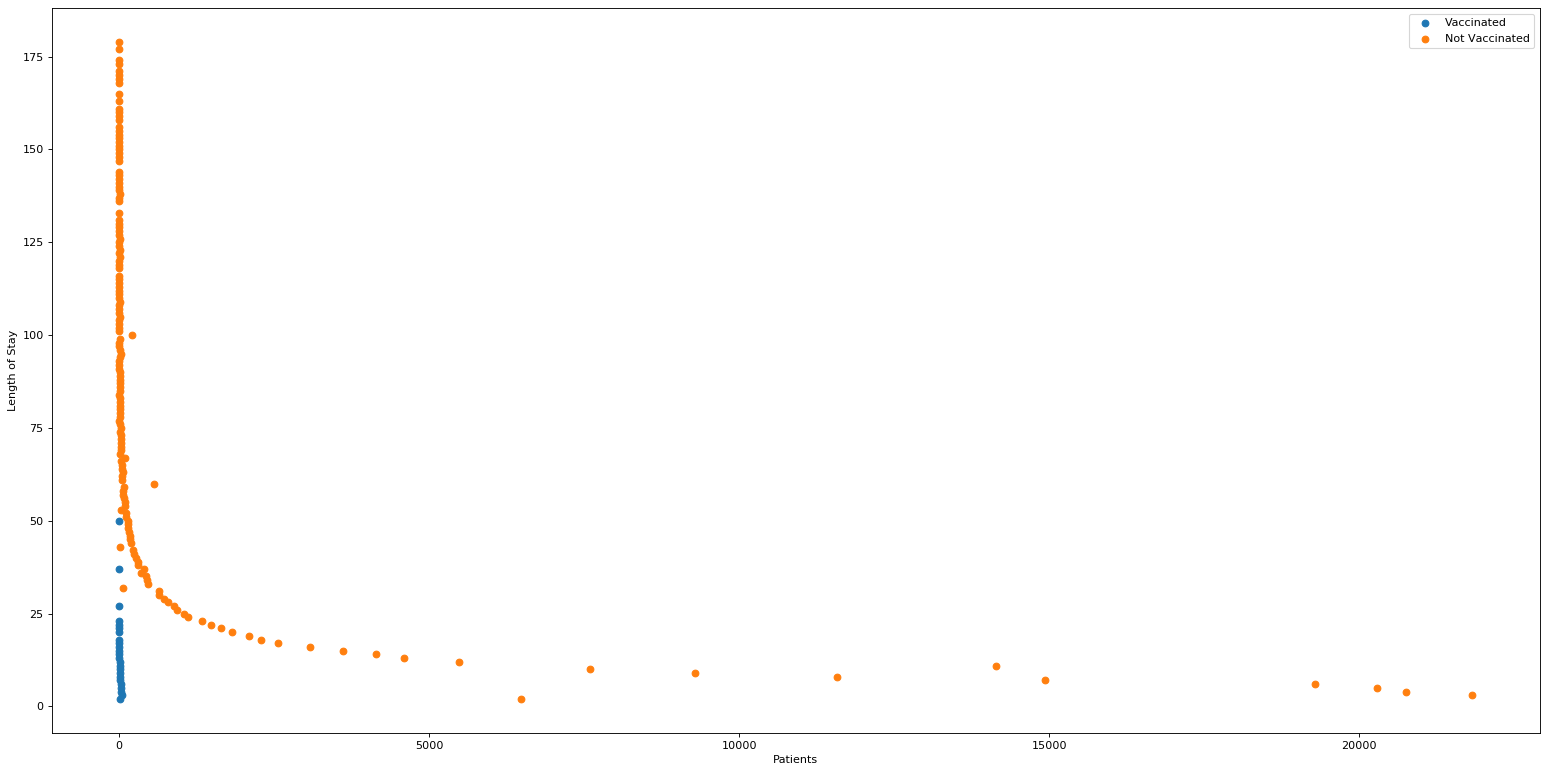

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(24, 12), dpi=80)
plt.scatter(x1, y1, label='Vaccinated')
plt.scatter(x0, y0, label='Not Vaccinated')


plt.ylabel("Length of Stay")
plt.xlabel("Patients")
plt.legend()

plt.show()

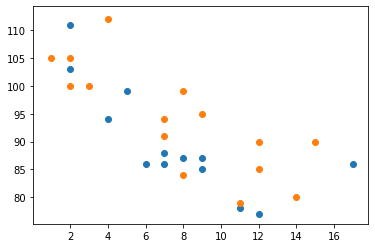

In [45]:
import matplotlib.pyplot as plt
import numpy as np

#day one, the age and speed of 13 cars:
x = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])
plt.scatter(x, y)

#day two, the age and speed of 15 cars:
x = np.array([2,2,8,1,15,8,12,9,7,3,11,4,7,14,12])
y = np.array([100,105,84,105,90,99,90,95,94,100,79,112,91,80,85])
plt.scatter(x, y)

plt.show()

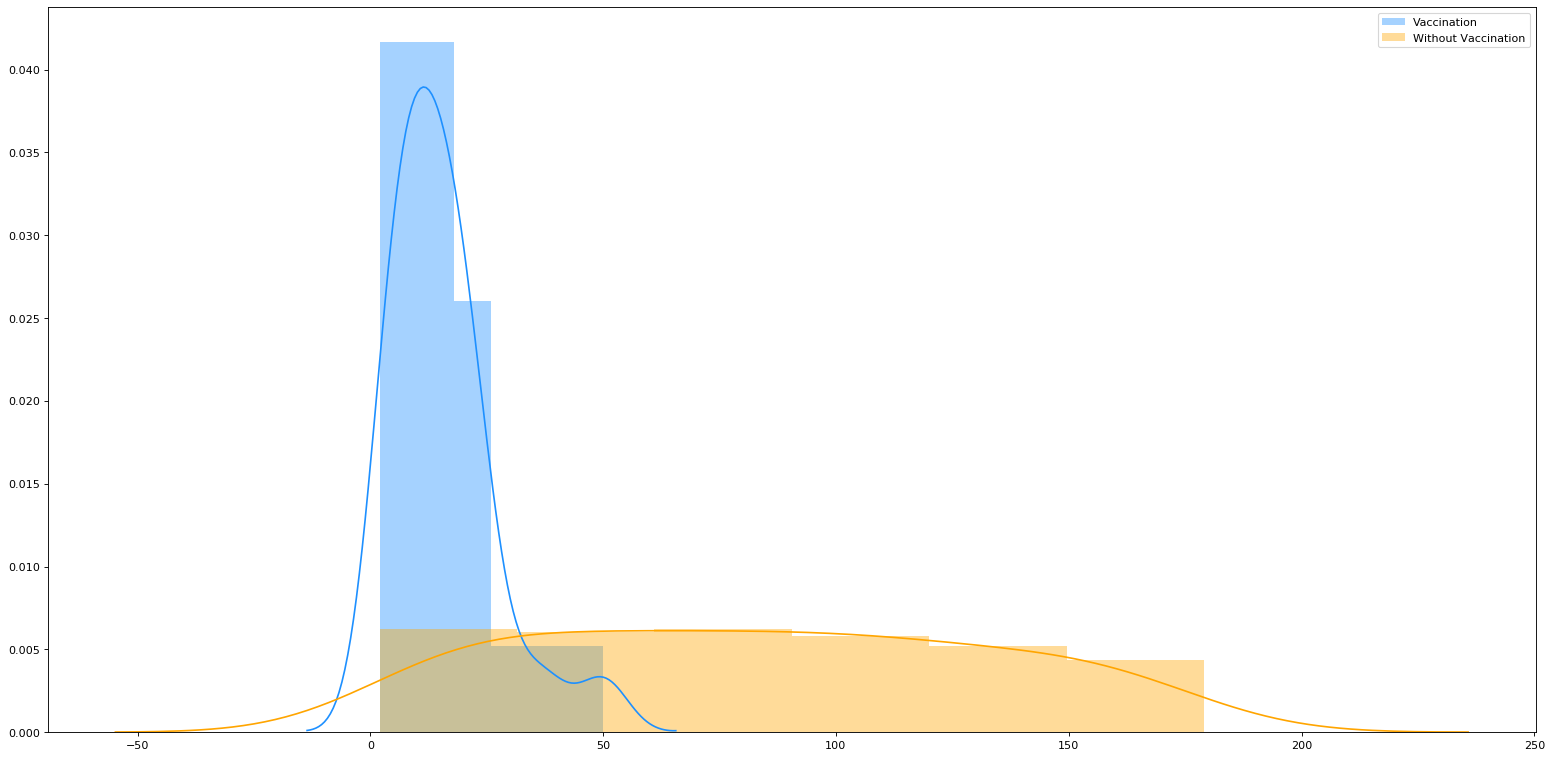

In [46]:
# Solution
import seaborn as sns


plt.subplots(figsize=(24,12), dpi=80)
sns.distplot( y1 , color="dodgerblue", label="Vaccination")
sns.distplot( y0 , color="orange", label="Without Vaccination")

#plt.title('Vaccination Histogram')
plt.legend();